In [24]:
import numpy as np
import torch
import torch.nn as nn
from data_init import class_incremental
from model_config import MyModel_Config
from pytorch_pretrained_bert import BertConfig, BertTokenizer, BertModel, BertForMaskedLM
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt   #jupyter要matplotlib.pyplot
from torch.utils.data import DataLoader, Dataset, TensorDataset
import random
from train_eval import Model_Train
import re
from tqdm import *
import pandas as pd
from pandas import DataFrame
from torch.distributions import Dirichlet

In [25]:
'''调整随机数'''
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(5)

In [26]:
'''利用增量数据初始化处理数据集'''
train_incremental = class_incremental('./data/snips/train.tsv', 'tsv', 64, 7, 5, True, 9999999) #最后的500表示每个类的数据个数限制
train_original_datas, train_incremental_datas_list, train_original_labels, train_all_incremental_labels, labels, label_to_idx = train_incremental.prepare_for_incremental()
train_Joint_datasets = train_incremental.Joint_incremental()

#初始化验证集的原始类和增量类数据
dev_incremental = class_incremental('./data/snips/dev.tsv', 'tsv', 64, 7, 5, True, 999999, 'eval', labels, label_to_idx)
dev_original_datas, dev_incremental_datas_list, dev_original_labels, dev_all_incremental_labels = dev_incremental.prepare_for_incremental()
dev_Joint_datasets = dev_incremental.Joint_incremental()

#初始化测试集的原始类和增量类数据
test_incremental = class_incremental('./data/snips/test.tsv', 'tsv', 64, 7, 5, True, 9999999, 'eval', labels, label_to_idx)
test_original_datas, test_incremental_datas_list, test_original_labels, test_all_incremental_labels = test_incremental.prepare_for_incremental()
test_Joint_datasets = test_incremental.Joint_incremental()

In [27]:
'''定义训练模型'''
class Teachermodel(nn.Module):
    def __init__(self,config):
        super(Teachermodel,self).__init__()
        self.bert=BertModel.from_pretrained(config.bert_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
 
        
        self.dropout=nn.Dropout(config.dropout)

        self.fc1 = nn.Linear(768, 256)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
     
        out=self.fc1(encoder_out[:,0,:])
 
        out = self.dropout(out)
        out = self.fc(out)
        
        return out


'''定义Bert生成模型。通过在一个OOD数据集训练让其输入噪声后可以输出在该OOD上的词汇集'''
class Bert_Gen(nn.Module):  #Bert生成模型
    def __init__(self, Bert_config): #tokens_len表示生成数据的长度,即最后bert要生成这么长的文本
        super(Bert_Gen,self).__init__()
        self.device = Bert_config.device
        
        self.bert1=BertModel.from_pretrained(Bert_config.bertmini_path)  #从路径加载预训练模型
        for param in self.bert1.parameters():
            param.requires_grad = True # 使参数可更新
        
        self.fc3= nn.Linear(Bert_config.hidden_size, 1024)
        self.fc4 = nn.Linear(1024, 30522)
    
    def forward(self, z): #tokens表示dataloader中的一个batch的tokens，即去掉label部分的token tensor
        

        out = z.long()#将经过线性层将正态分布z变为long型整数输入到bert
        
        encoder_out, pool = self.bert1(out.view(1,-1), output_all_encoded_layers=False) #得到每个token的向量表示
        
        out = self.fc3(encoder_out.squeeze())  
        out = F.relu(out)
        out = self.fc4(out)  #经过线性层处理生成新的向量，和bert词表大小相同
        out = F.gumbel_softmax(out, 10, True)
        
        return out  #输出一个batch的softmax [batch_size, 类别的softmax得分]


'''用于生成DI数据印象的模型'''
class DI_Gen_model(nn.Module):
    def __init__(self, teacher_model):
        super(DI_Gen_model,self).__init__()
        
        self.bert_gen = torch.load('./model/bert_genMINI3')
        for param in self.bert_gen.parameters():    
            param.requires_grad = True
            
        self.bert_cnn = teacher_model
        for param in self.bert_cnn.parameters():    
            param.requires_grad = False
            
    def forward(self, z):
        
        
        tokens = self.bert_gen(z)
        tokens = torch.argmax(tokens, dim=1, keepdim=False).long().view(1,-1)
        
        tokens = tokens.squeeze().tolist()
        tokens.append(102)#添加sep符号
        tokens.insert(0, 101) #添加cls符号
        tokens = torch.tensor(tokens).view(1,-1).to('cuda:1')  #感觉加了之后要好一些
        
        self.bert_cnn.eval()
        out = self.bert_cnn(tokens) #输入(batch_size=1, token_len)的tokens, 输出(batch_size=1, num_classes)的out
        
        return out, tokens



In [28]:
'''student模型'''
class Bert_student(nn.Module):
    def __init__(self,config):
        super(Bert_student,self).__init__()
        self.bert=BertModel.from_pretrained(config.bertmini_path)  
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.dropout=nn.Dropout(config.dropout)
        self.fc = nn.Linear(256, config.num_classes ) 


    def forward(self, tokens):

    
        encoder_out,pooled = self.bert(tokens,output_all_encoded_layers=False) 
        out=self.fc(encoder_out[:,0,:])
        out = self.dropout(out)
        
        return out

In [29]:
'''利用原始数据训练并保存Teacher model'''
print('*******************原始数据训练Teacher model**********************')
teacher_model = Teachermodel(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(teacher_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train().my_train(teacher_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(teacher_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train().eval_for_incremental(teacher_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [29:42<00:00, 178.30s/it]


训练集精度变化[0.9849877450980392, 0.9928002450980392, 0.9954810049019608, 0.9967830882352942, 0.9975490196078431, 0.9977787990196079, 0.9980851715686274, 0.9984681372549019, 0.9999234068627451, 1.0]
验证集最终精度0.9890625
测试集最终精度0.971875


In [30]:
'''利用原始数据训练并保存student model'''
print('*******************原始数据训练Teacher model**********************')
student_model = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5)
loss_fuc = nn.CrossEntropyLoss()

'''训练模型，得到精度'''
accuracy_train, loss_train = Model_Train().my_train(student_model, loss_fuc, optimizer, 10, train_original_datas)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_fuc)
accuracy_test, loss_test = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_fuc)
print('训练集精度变化'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************原始数据训练Teacher model**********************


100%|██████████| 10/10 [03:27<00:00, 20.73s/it]


训练集精度变化[0.9440104166666666, 0.9682904411764706, 0.975796568627451, 0.9800091911764706, 0.9856770833333334, 0.9874387254901961, 0.9895067401960784, 0.9892003676470589, 0.9918811274509803, 0.9919577205882353]
验证集最终精度0.9890625
测试集最终精度0.9703125


In [31]:
last_layer_weight = teacher_model.fc.weight.detach().to('cpu')  #去除梯度
concent_params = torch.zeros([last_layer_weight.shape[0], last_layer_weight.shape[0]])
for i in range(len(last_layer_weight)):
    for j in range(len(last_layer_weight)):
        param = torch.matmul(last_layer_weight[i],last_layer_weight[j])
        param = param / (torch.norm(last_layer_weight[i]) * torch.norm(last_layer_weight[j]))  #计算最后一层权重的关系
        concent_params[i][j] = param
        
    max_val = torch.max(concent_params[i])
    min_val = torch.min(concent_params[i])
    concent_params[i] = (concent_params[i] - min_val + 1e-7) / (max_val-min_val)   #加上1e-7防止有0存在
    
labels = train_original_labels #绘图用到的标签

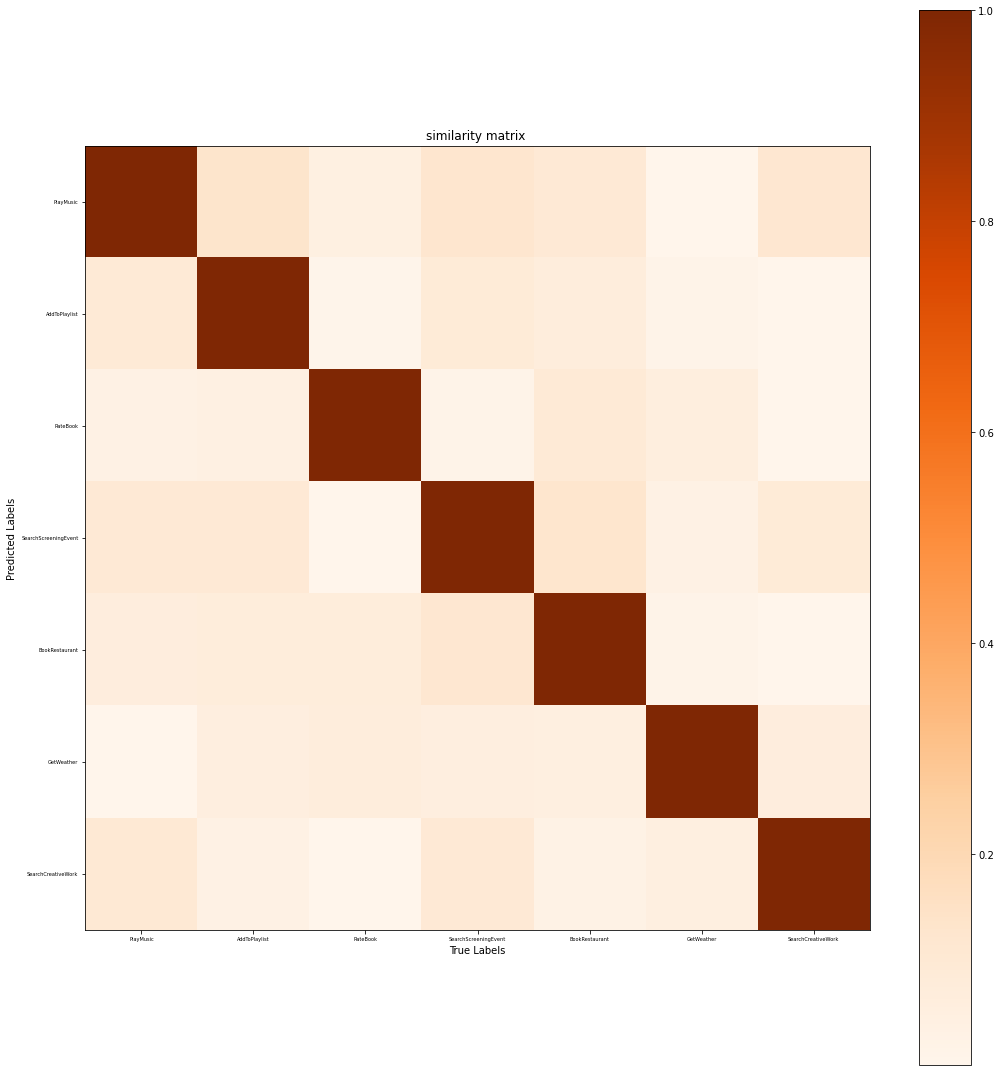

In [32]:
'''相似度矩阵绘制'''
def similar_matrix_plot(concent_params, num_classes, labels):#绘制混淆矩阵
    matrix = concent_params.numpy()  #先放在numpy上才能作图
    plt.figure(figsize=(15,15))  #设置画布大小
    plt.imshow(matrix, cmap=plt.cm.Oranges)
  
    # 设置x轴坐标label
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, labels,fontsize=5)
    plt.yticks(tick_marks, labels,fontsize=5)
        # 显示colorbar
    plt.colorbar()
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('similarity matrix ')

    plt.tight_layout()
    plt.show()

similar_matrix_plot(concent_params, len(train_original_labels), labels)

In [33]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

ood_num = 16000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        ood_datas.append(temp[i])
        
print(len(ood_datas))

100%|██████████| 760542/760542 [20:25<00:00, 620.47it/s]  


15774


In [34]:
'''训练DI生成模型'''
def train_DI_gen(dir_samples, ood_data, DI_gen, optimizer, loss_func, loss_func2, label, temper=10, error=1.2, max_iter=True):
    device = 'cuda:1'
    DI_gen = DI_gen.to(device)
    loss_num=999
    tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
    DI_gen.train()
    for i in range(len(dir_samples)):
        count = 0
        ood_data = ood_data.view(-1,1).to(device)
        #z = torch.randn(30,1).to(device)
        tokens_gens=torch.tensor([]).to(device) #选择最小损失的tokens
        losses = torch.tensor([]) #保存对应的损失
        while loss_num > error:  
            
            if max_iter == True and count>=300:  #是否设置最大迭代次数1200
                break
            
            optimizer.zero_grad()
            
            label = label.to(device).long()
            dir_sample = dir_samples[i].to(device).view(1,-1)
            
            probs, tokens_gen = DI_gen(ood_data)
            
            #loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_sample)
            #loss = 0.6*loss_func2(probs, label)
            loss = loss_func(F.log_softmax(probs / temper, dim=1), dir_sample) + 0.6*loss_func2(probs, label) #如果不加后面的硬性指标会使得预测的标签混乱
            loss_num = loss.item()
            
            loss.requires_grad_(True) #这里应该是因为如果将最后一层的模型参数梯度关闭，则计算出来的loss也没有梯度，不能追踪，所以要将loss的梯度设置为True
            loss.backward()
            optimizer.step()
            count += 1
            
            if count%2==0:
                tokens_gens = torch.cat([tokens_gens, tokens_gen], dim=0)
                losses = torch.cat([losses, torch.tensor([loss_num])])
                #print(loss_num)
        #print('训练过程中bert_cnn的预测情况'+str(torch.argmax(probs)))
            
    if max_iter == True and len(tokens_gens) > 0:
        tokens_gen = tokens_gens[torch.argmin(losses).item()]  #选择loss最小的
            
    return tokens_gen
        

In [35]:
'''定义理想情况，DI数据应该对应的真实标签'''
DI_num = len(ood_datas)
DI_labels = torch.tensor([])
for i in range(len(train_original_labels)):
    for k in [1,5]:
        for j in range(int(DI_num/len(train_original_labels)/2)):
            DI_labels = torch.cat([DI_labels, torch.tensor([i])])

In [36]:
'''定义DI的生成模型，以及损失函数和优化器'''
DI_gen = DI_Gen_model(teacher_model)
loss_func = nn.KLDivLoss(reduction = 'mean')
loss_func2 = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(DI_gen.parameters(), lr=1e-5)

'''生成训练集的DI'''
DI_num = len(ood_datas)
DI_datas = torch.tensor([])
ood_idx = 0
for i in range(len(train_original_labels)):  #标签的idx刚好和train_original_labels的下标顺序对应

    for k in [0.5,0.8]:  #每种β生成1/2的数据
        m = Dirichlet(k*concent_params[i])  #采样每个类的数据
        
        for j in tqdm(range(int(DI_num/len(train_original_labels)/2))):
            x = m.sample().view(1,-1)
            
            DI_gen = DI_Gen_model(teacher_model)
            optimizer = torch.optim.SGD(DI_gen.parameters(), lr=1e-5)
            
            tokens = train_DI_gen(x, torch.tensor(ood_datas[ood_idx]), DI_gen, optimizer, loss_func, loss_func2, torch.tensor([i]))
            ood_idx += 1
            
            tokens = tokens.squeeze().tolist()
            while len(tokens)<100:
                tokens.append(0)  #padding到100
        
            tokens = torch.tensor(tokens)
            DI_datas = torch.cat([DI_datas, tokens.to('cpu').view(1,-1)], dim=0)
            
            '''
            bert_cnn.eval()
            bert_cnn = bert_cnn.to('cuda:1')
            with torch.no_grad():
                out = bert_cnn(tokens.to('cuda:1').long().view(1,-1))
                print('当前bert_cnn对本token的预测情况'+str(torch.argmax(F.softmax(out), dim=1)))
            
            bert_cnn.eval()
            bert_cnn = bert_cnn.to('cuda:1')
            with torch.no_grad():
                out = bert_cnn(DI_datas.to('cuda:1').long())
                print(torch.argmax(F.softmax(out), dim=1))
            '''


  0%|          | 0/1126 [00:00<?, ?it/s]/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/torch/nn/functional.py:2398: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 1126/1126 [06:13<00:00,  3.01it/s]


In [37]:
'''随机测试DI对应的英文'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
text = tokenizer.convert_ids_to_tokens(DI_datas[10].tolist())
print(text)

DI_datasets = TensorDataset(DI_datas.long())
DI_datasets = DataLoader(DI_datasets, batch_size=128, shuffle=False, drop_last=False, num_workers=2)

'''观察生成DI数据的预测标签特性'''
teacher_model.eval()
teacher_model = teacher_model.to('cuda:1')
DI_pred_labels = torch.tensor([])
with torch.no_grad():
    for i, data in enumerate(DI_datasets):
        out = teacher_model(data[0].to('cuda:1').long())
        DI_pred = torch.argmax(F.softmax(out), dim=1) #DI数据输入到bert_cnn中对应的标签
        DI_pred_labels = torch.cat([DI_pred_labels, DI_pred.to('cpu')])

DI_pred_dict = {} #记录DI预测的不同种类标签个数
for i in range(len(train_original_labels)):
    DI_pred_dict[i] = 0
for i in range(len(DI_pred_labels)):
    DI_pred_dict[DI_pred_labels[i].item()] += 1 
print(DI_pred_dict)

['[CLS]', 'accuse', 'excessive', '[unused715]', 'を', 'sucked', 'enzyme', 'donnelly', 'aisle', 'prompt', 'ethanol', 'departed', 'aus', 'parent', 'dub', '104', '##aldi', 'went', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


/root/deepo/LYL/anaconda/ls/envs/csuse/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


{0: 590, 1: 2565, 2: 396, 3: 5238, 4: 51, 5: 89, 6: 6835}


In [38]:
'''将DI文件装入Dataloader中'''
DI_datasets = TensorDataset(DI_datas.long(), DI_pred_labels.long())
DI_datasets = DataLoader(DI_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [39]:
student_model.eval()
student_model = student_model.to('cuda:1')
with torch.no_grad():
    for i , data in enumerate(DI_datasets):
        test_output = student_model(data[0].to('cuda:1'))
        x = data[0]

In [40]:
print(torch.argmax(F.softmax(test_output, dim=1), dim=1))
indexs = torch.argmax(F.softmax(test_output, dim=1), dim=1).to('cpu')
print(F.softmax(test_output, dim=1))

tensor([1, 6, 6, 6, 6, 1, 6, 1, 6, 6, 1, 1, 6, 1, 3, 1, 1, 1, 6, 1, 1, 6, 6, 1,
        6, 6, 1, 5, 6, 6, 6, 1, 1, 1, 1, 6, 1, 1, 6, 6, 1, 1, 1, 6, 6, 1, 2, 6,
        1, 6, 6, 1, 6, 1, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 1, 0,
        1, 6, 6, 6, 6, 1, 6, 0, 1, 6, 6, 1, 1, 1, 6, 1, 6, 6, 1, 1, 5, 1, 6, 1,
        1, 1, 1, 6, 1, 1, 6, 6, 1, 6, 1, 1, 6, 6, 1, 1, 0, 6, 6, 6, 1, 1, 1, 6,
        6, 1, 1, 6, 6, 1, 1, 1], device='cuda:1')
tensor([[0.0676, 0.5149, 0.0347, 0.0387, 0.0172, 0.0164, 0.3105],
        [0.0316, 0.3164, 0.1102, 0.0681, 0.0098, 0.0630, 0.4009],
        [0.1840, 0.1163, 0.0123, 0.0265, 0.0061, 0.0186, 0.6361],
        [0.0458, 0.1628, 0.0462, 0.0170, 0.0079, 0.0205, 0.6997],
        [0.0286, 0.4435, 0.0275, 0.0353, 0.0096, 0.0100, 0.4454],
        [0.0258, 0.5832, 0.0478, 0.0352, 0.0292, 0.0068, 0.2719],
        [0.0262, 0.2595, 0.0267, 0.0336, 0.0081, 0.0467, 0.5993],
        [0.0183, 0.7276, 0.0229, 0.0109, 0.0087, 0.0107, 0.2010],
        [0.0160, 0.124

In [41]:
for i in range(len(indexs)):
    print(F.softmax(test_output, dim=1)[i][indexs[i]])

tensor(0.5149, device='cuda:1')
tensor(0.4009, device='cuda:1')
tensor(0.6361, device='cuda:1')
tensor(0.6997, device='cuda:1')
tensor(0.4454, device='cuda:1')
tensor(0.5832, device='cuda:1')
tensor(0.5993, device='cuda:1')
tensor(0.7276, device='cuda:1')
tensor(0.7406, device='cuda:1')
tensor(0.5914, device='cuda:1')
tensor(0.6276, device='cuda:1')
tensor(0.6587, device='cuda:1')
tensor(0.4890, device='cuda:1')
tensor(0.5008, device='cuda:1')
tensor(0.3651, device='cuda:1')
tensor(0.5124, device='cuda:1')
tensor(0.5516, device='cuda:1')
tensor(0.7718, device='cuda:1')
tensor(0.5706, device='cuda:1')
tensor(0.5675, device='cuda:1')
tensor(0.9067, device='cuda:1')
tensor(0.3899, device='cuda:1')
tensor(0.4606, device='cuda:1')
tensor(0.3991, device='cuda:1')
tensor(0.7830, device='cuda:1')
tensor(0.6601, device='cuda:1')
tensor(0.7252, device='cuda:1')
tensor(0.7312, device='cuda:1')
tensor(0.7003, device='cuda:1')
tensor(0.4939, device='cuda:1')
tensor(0.4830, device='cuda:1')
tensor(0

In [42]:
student_model.eval()
student_model = student_model.to('cuda:1')
with torch.no_grad():
    count = 0
    test_num = 0
    for i , data in enumerate(DI_datasets):
        test_output = student_model(data[0].to('cuda:1'))
        idxs = torch.argmax(F.softmax(test_output, dim=1), dim=1).to('cpu')
        for j in range(len(idxs)):
            if F.softmax(test_output, dim=1)[j][idxs[j]] > 0.50:
                count+=1
            test_num += 1
print(count)
print(test_num)

10684
15744


In [43]:
'''尝试2019DI的zero-shot蒸馏student模型的训练函数
参数：
teacher_model:被提取的模型
student_model:要提取出的模型
datas:DI生成的数据，用Dataloader封装
optimizer:优化器，只优化student_model的参数
loss_func:采用KL散度，或是MSE等保持teacher和student的softmax输出的相似性
temper:KL散度的温度系数,不能设置太高，经过实验探究，设置到4左右效果最好
'''
def train_KD_student(teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs , train_original_datas, dev_original_datas, test_original_datas):
    device = 'cuda:1'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []
    
    max_acc_fin = 0 #记录最终最大精度测试集组并输出
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    for epoch in tqdm(range(epochs)):
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            student_model.train()
            tokens = data[0].to(device)
            #labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
            with torch.no_grad():
                probs_teacher = teacher_model(tokens)
            
            probs_student = student_model(tokens)
            
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1))
            #loss = 0.8*loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.2*loss_func2(probs_student, labels)
            loss.backward()  #这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            
            student_model.eval()
            accuracy_test, _ = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train().eval_for_incremental(student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
               

In [44]:
'''定义用zero-shot KD训练的student模型和损失函数和优化器'''

print('*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')

bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

accuracy_train, _ = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, _ = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, _ = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print(accuracy_train)
print(accuracy_dev)
print(accuracy_test)

train_KD_student(teacher_model, bert_student, DI_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)
#train_KD_student(bert_cnn, bert_cnn_student, DI_datasets_padding, optimizer, loss_func, loss_func2, 5, 30) #用padding后的DI来KD，对比OOD

*******************利用DI训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************
0.17080269607843138
0.1359375
0.1359375


  3%|▎         | 1/30 [01:48<52:31, 108.68s/it]

训练集精度0.19087009803921567
验证集精度0.2140625
测试集精度0.2140625


  7%|▋         | 2/30 [05:34<1:22:59, 177.82s/it]

训练集精度0.5961243872549019
验证集精度0.596875
测试集精度0.5828125


 10%|█         | 3/30 [07:42<1:09:47, 155.09s/it]

训练集精度0.6387867647058824
验证集精度0.646875
测试集精度0.64375


 13%|█▎        | 4/30 [10:04<1:04:50, 149.64s/it]

训练集精度0.7214307598039216
验证集精度0.721875
测试集精度0.7125


 17%|█▋        | 5/30 [12:44<1:03:59, 153.57s/it]

训练集精度0.8111213235294118
验证集精度0.809375
测试集精度0.8109375


 20%|██        | 6/30 [14:58<58:43, 146.82s/it]  

训练集精度0.8241421568627451
验证集精度0.8328125
测试集精度0.834375


 23%|██▎       | 7/30 [17:16<55:11, 143.96s/it]

训练集精度0.8540900735294118
验证集精度0.85625
测试集精度0.8453125


 27%|██▋       | 8/30 [19:32<51:48, 141.29s/it]

训练集精度0.858609068627451
验证集精度0.8703125
测试集精度0.8578125


 30%|███       | 9/30 [21:48<48:53, 139.69s/it]

训练集精度0.8705575980392157
验证集精度0.8765625
测试集精度0.8734375


 33%|███▎      | 10/30 [23:47<44:30, 133.50s/it]

训练集精度0.8772212009803921
验证集精度0.884375
测试集精度0.8765625


 37%|███▋      | 11/30 [25:53<41:29, 131.04s/it]

训练集精度0.8802083333333334
验证集精度0.89375
测试集精度0.875


 40%|████      | 12/30 [27:39<37:03, 123.53s/it]

训练集精度0.8789828431372549
验证集精度0.8890625
测试集精度0.8765625


 43%|████▎     | 13/30 [29:43<35:00, 123.56s/it]

训练集精度0.8860294117647058
验证集精度0.89375
测试集精度0.875


 47%|████▋     | 14/30 [31:47<33:00, 123.79s/it]

训练集精度0.8935355392156863
验证集精度0.9046875
测试集精度0.8765625


 50%|█████     | 15/30 [33:49<30:48, 123.23s/it]

训练集精度0.8965226715686274
验证集精度0.921875
测试集精度0.884375


 53%|█████▎    | 16/30 [35:55<28:54, 123.87s/it]

训练集精度0.8896292892156863
验证集精度0.9109375
测试集精度0.878125


 57%|█████▋    | 17/30 [37:52<26:24, 121.86s/it]

训练集精度0.8884803921568627
验证集精度0.9015625
测试集精度0.88125


 60%|██████    | 18/30 [39:51<24:11, 120.97s/it]

训练集精度0.8808976715686274
验证集精度0.9015625
测试集精度0.8796875


 63%|██████▎   | 19/30 [41:50<22:04, 120.40s/it]

训练集精度0.9057904411764706
验证集精度0.91875
测试集精度0.884375


 67%|██████▋   | 20/30 [43:53<20:13, 121.32s/it]

训练集精度0.9029564950980392
验证集精度0.9140625
测试集精度0.8859375


 70%|███████   | 21/30 [45:59<18:25, 122.78s/it]

训练集精度0.91015625
验证集精度0.9296875
测试集精度0.8890625


 73%|███████▎  | 22/30 [48:05<16:30, 123.77s/it]

训练集精度0.907015931372549
验证集精度0.921875
测试集精度0.8859375


 77%|███████▋  | 23/30 [50:04<14:15, 122.25s/it]

训练集精度0.9125306372549019
验证集精度0.925
测试集精度0.8890625


 80%|████████  | 24/30 [51:57<11:56, 119.47s/it]

训练集精度0.9028799019607843
验证集精度0.921875
测试集精度0.8890625


 83%|████████▎ | 25/30 [54:05<10:09, 121.93s/it]

训练集精度0.9025735294117647
验证集精度0.921875
测试集精度0.8875


 87%|████████▋ | 26/30 [56:11<08:13, 123.28s/it]

训练集精度0.9026501225490197
验证集精度0.9203125
测试集精度0.8921875


 90%|█████████ | 27/30 [58:18<06:12, 124.20s/it]

训练集精度0.8956035539215687
验证集精度0.9140625
测试集精度0.8875


 93%|█████████▎| 28/30 [1:00:14<04:03, 121.80s/it]

训练集精度0.8991268382352942
验证集精度0.915625
测试集精度0.8859375


 97%|█████████▋| 29/30 [1:02:24<02:04, 124.31s/it]

训练集精度0.9003523284313726
验证集精度0.9109375
测试集精度0.8890625


100%|██████████| 30/30 [1:04:35<00:00, 129.17s/it]

训练集精度0.8998161764705882
验证集精度0.91875
测试集精度0.8875
训练集最终精度0.9026501225490197
验证集最终精度0.9203125
测试集最终精度0.8921875


In [45]:
'''读取OOD的wiki103数据'''
import os
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

paragraphs = _read_wiki('./wiki103')

In [46]:
'''将读取的wiki数据tokenize'''
tokenizer = BertTokenizer.from_pretrained('./bert-pretrained')
tokens = []
datas_size = len(paragraphs)
for l in tqdm(range(datas_size)):
    for k in range(len(paragraphs[l])):
        text = paragraphs[l][k]
        text = tokenizer.tokenize(text)
        token = tokenizer.convert_tokens_to_ids(text)
        tokens.append(token)

100%|██████████| 760542/760542 [20:16<00:00, 625.16it/s]  


In [47]:
ood_num = 16000
ood_datas = []
temp = [[] for i in range(len(tokens))] #这样防止temp和tokens地址相同
for i in range(len(tokens)):
    temp[i] = tokens[i]
for i in range(ood_num):  #Bert最长读512最少读2长度的tokens,所以要处理
    if len(temp[i]) <98 and len(temp[i])>2:
        temp[i].insert(0,101)
        temp[i].append(102)
        while len(tokens[i]) <100:
            temp[i].append(0)  #padding
        ood_datas.append(temp[i])
        
print(len(ood_datas))

15751


In [48]:
counts =0
for data in ood_datas:
    count = 0
    for j in range(len(data)):
        if data[j] == 0:
            break
        count += 1
    counts += count
ave = counts / len(ood_datas)
print('选取ood数据的平均长度为：'+ str(ave))

选取ood数据的平均长度为：31.243857532855056


In [49]:
ood_datasets = TensorDataset(torch.tensor(ood_datas).long())
ood_datasets = DataLoader(ood_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

In [50]:
OOD_number = 8000
ood_datas_2 = torch.tensor([])

for i,data in enumerate(ood_datasets):
    if len(ood_datas_2) > 8000:
        break
    ood_datas_2 = torch.cat([ood_datas_2, data[0]], dim=0)
ood_datasets_4000 = TensorDataset(ood_datas_2.long())
ood_datasets_4000 = DataLoader(ood_datasets_4000, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

In [51]:
'''用ood数据直接进行KL散度蒸馏studentmodel'''
print('*******************利用ood训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************')
bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

train_KD_student(teacher_model, bert_student, ood_datasets, optimizer, loss_func, loss_func2, 5, 30, train_original_datas, dev_original_datas, test_original_datas)
accuracy_train, loss_train = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, loss_test = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print('训练集最终精度'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))


*******************利用ood训练student model，加上student与teachermodel对DI的softmax输出KL散度做损失****************************


  3%|▎         | 1/30 [03:15<1:34:22, 195.27s/it]

训练集精度0.6183363970588235
验证集精度0.609375
测试集精度0.6234375


  7%|▋         | 2/30 [05:32<1:15:16, 161.30s/it]

训练集精度0.6929381127450981
验证集精度0.678125
测试集精度0.70625


 10%|█         | 3/30 [07:47<1:07:07, 149.15s/it]

训练集精度0.754672181372549
验证集精度0.746875
测试集精度0.7671875


 13%|█▎        | 4/30 [09:53<1:00:43, 140.14s/it]

训练集精度0.8435968137254902
验证集精度0.859375
测试集精度0.834375


 17%|█▋        | 5/30 [11:55<55:41, 133.64s/it]  

训练集精度0.8355545343137255
验证集精度0.8234375
测试集精度0.8359375


 20%|██        | 6/30 [14:12<53:47, 134.48s/it]

训练集精度0.8496476715686274
验证集精度0.8484375
测试集精度0.8484375


 23%|██▎       | 7/30 [16:16<50:18, 131.26s/it]

训练集精度0.8602175245098039
验证集精度0.8625
测试集精度0.846875


 27%|██▋       | 8/30 [18:17<46:57, 128.05s/it]

训练集精度0.8654258578431373
验证集精度0.878125
测试集精度0.8546875


 30%|███       | 9/30 [20:29<45:12, 129.16s/it]

训练集精度0.8754595588235294
验证集精度0.8796875
测试集精度0.85625


 33%|███▎      | 10/30 [22:34<42:38, 127.94s/it]

训练集精度0.8748468137254902
验证集精度0.878125
测试集精度0.8609375


 37%|███▋      | 11/30 [24:43<40:36, 128.23s/it]

训练集精度0.871859681372549
验证集精度0.8828125
测试集精度0.859375


 40%|████      | 12/30 [26:50<38:19, 127.75s/it]

训练集精度0.8770680147058824
验证集精度0.8796875
测试集精度0.878125


 43%|████▎     | 13/30 [28:52<35:45, 126.22s/it]

训练集精度0.8813572303921569
验证集精度0.8921875
测试集精度0.8703125


 47%|████▋     | 14/30 [30:50<32:58, 123.63s/it]

训练集精度0.8802083333333334
验证集精度0.8859375
测试集精度0.8640625


 50%|█████     | 15/30 [32:56<31:03, 124.21s/it]

训练集精度0.8801317401960784
验证集精度0.88125
测试集精度0.875


 53%|█████▎    | 16/30 [34:54<28:32, 122.33s/it]

训练集精度0.8763020833333334
验证集精度0.8796875
测试集精度0.8703125


 57%|█████▋    | 17/30 [37:03<26:59, 124.57s/it]

训练集精度0.8836550245098039
验证集精度0.878125
测试集精度0.878125


 60%|██████    | 18/30 [39:20<25:39, 128.31s/it]

训练集精度0.8811274509803921
验证集精度0.8734375
测试集精度0.8765625


 63%|██████▎   | 19/30 [41:15<22:46, 124.25s/it]

训练集精度0.8812806372549019
验证集精度0.8765625
测试集精度0.875


 67%|██████▋   | 20/30 [43:21<20:46, 124.69s/it]

训练集精度0.8851868872549019
验证集精度0.88125
测试集精度0.878125


 70%|███████   | 21/30 [45:34<19:06, 127.34s/it]

训练集精度0.8821231617647058
验证集精度0.88125
测试集精度0.8765625


 73%|███████▎  | 22/30 [47:46<17:09, 128.63s/it]

训练集精度0.8771446078431373
验证集精度0.8796875
测试集精度0.871875


 77%|███████▋  | 23/30 [49:48<14:47, 126.77s/it]

训练集精度0.8684129901960784
验证集精度0.8734375
测试集精度0.871875


 80%|████████  | 24/30 [51:55<12:39, 126.59s/it]

训练集精度0.8805912990196079
验证集精度0.8875
测试集精度0.871875


 83%|████████▎ | 25/30 [54:04<10:37, 127.47s/it]

训练集精度0.874234068627451
验证集精度0.8703125
测试集精度0.871875


 87%|████████▋ | 26/30 [56:14<08:32, 128.21s/it]

训练集精度0.8766850490196079
验证集精度0.8734375
测试集精度0.8796875


 90%|█████████ | 27/30 [58:29<06:30, 130.16s/it]

训练集精度0.8779871323529411
验证集精度0.8734375
测试集精度0.8796875


 93%|█████████▎| 28/30 [1:00:22<04:09, 124.99s/it]

训练集精度0.8771446078431373
验证集精度0.884375
测试集精度0.875


 97%|█████████▋| 29/30 [1:02:31<02:06, 126.39s/it]

训练集精度0.8730851715686274
验证集精度0.875
测试集精度0.86875


100%|██████████| 30/30 [1:04:23<00:00, 128.77s/it]

训练集精度0.8743106617647058
验证集精度0.8625
测试集精度0.8796875
训练集最终精度0.8766850490196079
验证集最终精度0.8734375
测试集最终精度0.8796875


训练集最终精度0.8575367647058824
验证集最终精度0.840625
测试集最终精度0.8453125


In [52]:
'''Hinton few-shotKD'''
def train_HintonKD_student(teacher_model, student_model, datas, optimizer, loss_func, loss_func2, temper, epochs, train_original_datas, dev_original_datas, test_original_datas ):
    device = 'cuda:1'
    teacher_model = teacher_model.to(device)
    student_model = student_model.to(device)
    teacher_model.eval()
    student_model.train()
    
    losses = [] #存放所有样本一个epoch的损失
    accuracies = []

    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)#每一轮epoch学习率递减
    max_acc_fin = 0
    for epoch in tqdm(range(epochs)):
        
        max_acc_test = 0
        '''对每个batch的训练'''
        for idx, data in enumerate(datas):  #idx表示第几个batch，datas为[batch_size, tokens, label]的数据
            
            student_model.train()
            tokens = data[0].to(device)
            labels = data[1].to(device)
        
            optimizer.zero_grad() #新batch训练时将梯度归0，防止梯度累积
            
            with torch.no_grad():
                probs_teacher = teacher_model(tokens)
            
            probs_student = student_model(tokens)
 
            loss = loss_func(F.log_softmax(probs_student / temper, dim=1), F.softmax(probs_teacher / temper, dim=1)) + 0.5*loss_func2(probs_student, labels)
            loss.backward()#这里不用loss.requires_grad_(True)的原因是优化器优化的参数中间步骤不包括梯度不动的teacher_model
            optimizer.step()
            #scheduler.step()#学习率递减
            
            student_model.eval()
            accuracy_test, _ = Model_Train().eval_for_incremental(student_model, test_original_datas, loss_func2)
            
            if max_acc_test<accuracy_test:
                max_acc_test = accuracy_test
                accuracy_train, _ = Model_Train().eval_for_incremental(student_model, train_original_datas, loss_func2)
                accuracy_dev, _ = Model_Train().eval_for_incremental(student_model, dev_original_datas, loss_func2)
        
        print('训练集精度'+str(accuracy_train))
        print('验证集精度'+str(accuracy_dev))
        print('测试集精度'+str(max_acc_test))
        
        if max_acc_fin<max_acc_test:
            max_acc_fin = max_acc_test
            accuracy_train_fin = accuracy_train
            accuracy_dev_fin = accuracy_dev

        student_model.train()
    
    print('训练集最终精度'+str(accuracy_train_fin))
    print('验证集最终精度'+str(accuracy_dev_fin))
    print('测试集最终精度'+str(max_acc_fin))
            
               

In [53]:
'''随机保存一定数量（和DI数量相同做对比）的原始数据，各个类别保存数量相等'''
print('***********************随机保存一定数量的原始数据训练student model,即hinton的few-shot KD******************')
reserve_num=2000 #一共保存用于KD多少个数据
data_num = [0 for i in range(len(train_original_labels))] #记录当前时刻每一类保存了多少个数据
tokens_reserved = torch.tensor([])  #用于保存数据
labels_reserved = torch.tensor([])

for _, data in enumerate(train_original_datas):
    for j in range(len(data[1])):
        if data_num[data[1][j].item()] < int(reserve_num/len(train_original_labels)): 
            tokens_reserved = torch.cat([tokens_reserved, data[0][j].view(1,-1)], dim=0)
            labels_reserved = torch.cat([labels_reserved, data[1][j].view(1)])
            data_num[data[1][j].item()] += 1

'''将保存的数据装入Dataloader中'''
reserved_datasets = TensorDataset(tokens_reserved.long(), labels_reserved.long())
reserved_datasets = DataLoader(reserved_datasets, batch_size=128, shuffle=True, drop_last=True, num_workers=2)

'''定义用zero-shot KD训练的student模型和损失函数和优化器'''
bert_student = Bert_student(MyModel_Config(train_original_labels))
optimizer = torch.optim.AdamW(bert_student.parameters(), lr=1e-4)
loss_func = nn.KLDivLoss()
loss_func2 = nn.CrossEntropyLoss()

'''hinton方法KD得到的模型精度'''
train_HintonKD_student(teacher_model, bert_student, reserved_datasets, optimizer, loss_func, loss_func2, 5, 10, train_original_datas, dev_original_datas, test_original_datas)
accuracy_reserved, loss_reserved = Model_Train().eval_for_incremental(bert_student, reserved_datasets, loss_func2)
accuracy_train, loss_train = Model_Train().eval_for_incremental(bert_student, train_original_datas, loss_func2)
accuracy_dev, loss_dev = Model_Train().eval_for_incremental(bert_student, dev_original_datas, loss_func2)
accuracy_test, loss_test = Model_Train().eval_for_incremental(bert_student, test_original_datas, loss_func2)
print('保存数据集精度'+str(accuracy_reserved))
print('训练集最终精度'+str(accuracy_train))
print('验证集最终精度'+str(accuracy_dev))
print('测试集最终精度'+str(accuracy_test))

***********************随机保存一定数量的原始数据训练student model,即hinton的few-shot KD******************


 10%|█         | 1/10 [00:31<04:40, 31.13s/it]

训练集精度0.8581495098039216
验证集精度0.8390625
测试集精度0.8296875


 20%|██        | 2/10 [01:02<04:09, 31.13s/it]

训练集精度0.9507506127450981
验证集精度0.9453125
测试集精度0.934375


 30%|███       | 3/10 [01:23<03:05, 26.52s/it]

训练集精度0.9646139705882353
验证集精度0.9671875
测试集精度0.9421875


 40%|████      | 4/10 [01:39<02:14, 22.41s/it]

训练集精度0.9715073529411765
验证集精度0.9734375
测试集精度0.946875


 50%|█████     | 5/10 [01:52<01:35, 19.20s/it]

训练集精度0.9771752450980392
验证集精度0.978125
测试集精度0.9609375


 60%|██████    | 6/10 [02:13<01:18, 19.75s/it]

训练集精度0.9793964460784313
验证集精度0.978125
测试集精度0.965625


 70%|███████   | 7/10 [02:31<00:57, 19.20s/it]

训练集精度0.9799325980392157
验证集精度0.9796875
测试集精度0.9703125


 80%|████████  | 8/10 [02:52<00:39, 19.60s/it]

训练集精度0.9792432598039216
验证集精度0.9828125
测试集精度0.9703125


 90%|█████████ | 9/10 [03:11<00:19, 19.41s/it]

训练集精度0.9811580882352942
验证集精度0.978125
测试集精度0.96875


100%|██████████| 10/10 [03:24<00:00, 20.46s/it]

训练集精度0.9778645833333334
验证集精度0.9828125
测试集精度0.971875
训练集最终精度0.9778645833333334
验证集最终精度0.9828125
测试集最终精度0.971875


保存数据集精度0.996875
训练集最终精度0.9823835784313726
验证集最终精度0.9796875
测试集最终精度0.9609375
